## Compute Graph Features on a Toy Graph

First we build a simple graph with networkx for example purpose

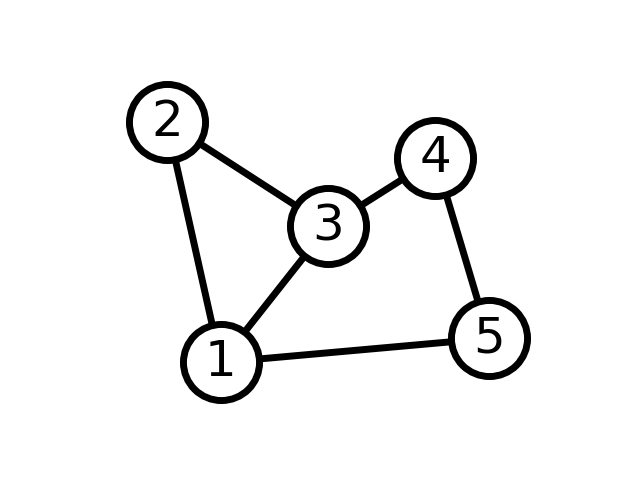

Not that in the code below we define a directed graph with multiedges. Please note, that compared to the graph above, there are two edges between nodes 4 and 5.

In [1]:
import networkx as nx

G = nx.MultiDiGraph()
G.add_edge(0, 1)
G.add_edge(0, 2)
G.add_edge(0, 4)
G.add_edge(1, 2)
G.add_edge(2, 3)
G.add_edge(3, 4)
G.add_edge(3, 4)
nx_df = nx.to_pandas_edgelist(G)
nx_df

,source,target
0,0,1
1,0,2
2,0,4
3,1,2
4,2,3
5,3,4
6,3,4


Now we will convert this graph to the cugraph format (will transfer it to GPU).

In [ ]:
import cugraph as cg

Gg = cg.MultiDiGraph()
Gg.from_pandas_edgelist(nx_df, source="source", destination="target")

In [3]:
Gg.edges()

,src,dst
0,0,1
1,0,2
2,0,4
3,1,2
4,2,3
5,3,4
6,3,4


## Extract descriptive graph-based features

Here we demonstrate how to compute the following graph features: 

- **pagerank** ~ a measure of 'popularity' of a node; PageRank is an algorithm used to rank websites in Google’s search results. It counts the number, and quality, of links to a page which determines an estimation of how important the page is. The underlying assumption is that pages of importance are more likely to receive a higher volume of links from other pages.

- **betweenness** ~ betweenness centrality is a way of detecting the amount of influence a node has over the flow of information in a graph. It is often used to find nodes that serve as a bridge from one part of a graph to another;

- **number of edges connected to a node** ~ one of basic structural properties;

- **number of unique neighbours** ~ another basic strutural property.

- **distance in embedding space** ~ given a knowledge graph we can learn graph representation for each node, so that a node is mapped to a vector of numbers (embedding). We can then use embeddings to conviently compute distances (similarities) between nodes in the graph.


### PageRank

In [4]:
cg.pagerank(Gg)

,pagerank,vertex
0,0.086773,0
1,0.261888,3
2,0.111359,1
3,0.206015,2
4,0.333965,4


### Betweenness Centrality

In [5]:
cg.betweenness_centrality(Gg)

,betweenness_centrality,vertex
0,0.000000,0
1,0.000000,3
2,0.000000,1
3,0.166667,2
4,0.000000,4


### Number of edges connected to a node

First we compute the in and out degrees of each nodes

In [6]:
degs = Gg.degrees()
degs

,in_degree,out_degree,vertex
0,0,3,0
1,1,2,3
2,1,1,1
3,2,1,2
4,3,0,4


Note that the vertex 5 has an in degree of 3, which means this method actually counts the number of edges, and not the number of neighbours! To get the number of edges attached to each vertex we just have to sum the number of ingoing and outgoing edges

In [7]:
degs["n_edges"] = degs["in_degree"]+degs["out_degree"]
degs

,in_degree,out_degree,vertex,n_edges
0,0,3,0,3
1,1,2,3,3
2,1,1,1,2
3,2,1,2,3
4,3,0,4,3


### Number of unique neighbours

For this feature we will reuse the degree method, but this time we will force the graph to be undirected and without multiedges, effectively counting the number of neighbours.

In [8]:
simpleG = cg.Graph(Gg)

In [9]:
simpleG.degrees()

,in_degree,out_degree,vertex
0,3,3,0
1,2,2,3
2,2,2,1
3,3,3,2
4,2,2,4


Since we have an undirected graph, both in and out degrees can be used as a count of neighbours

### Embedding distance

For this example we will use a simple embedding technique provided via the karateclub package

In [10]:

from karateclub.node_embedding.neighbourhood import SocioDim


In [11]:
model = SocioDim(dimensions=2)
model.fit(nx.Graph(G))
embedding = model.get_embedding()

In [12]:
embedding

array([[-5.00000000e-01, -2.42938075e-01],
       [-8.72846799e-18, -5.69829188e-01],
       [ 5.00000000e-01, -2.42938075e-01],
       [-5.00000000e-01,  5.27852669e-01],
       [ 5.00000000e-01,  5.27852669e-01]])

In [13]:
disease = embedding[2]
disease

array([ 0.5       , -0.24293807])

In [14]:
import numpy as np

In [15]:
L2_distance_to_disease = np.linalg.norm(np.subtract(embedding, disease), axis=1)